# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [1]:
%pylab inline
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import site

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(42)
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [2]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self,
                 gd_type='stochastic',
                 batch_size=1,
                 tolerance=1e-4,
                 max_iter=1000,
                 w0=None,
                 eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        batch_size: data subset size for SGD
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.batch_size = batch_size
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None

    def fit(self, X, y):
        """
        Fitting Logistic Regression model.

        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        if self.w0:
            self.w = self.w0
        else:
            self.w = np.zeros(X.shape[1])
        self.loss_history = [self.calc_loss(X, y)]
        X_subset = X
        y_subset = y
        for i in range(self.max_iter):
            # If SGD is selected, than we get random subset of data size of batch_size.
            if self.gd_type == "stochastic":
                indxs = np.random.choice(X.shape[0], self.batch_size, replace=False)
                X_subset = X[indxs]
                y_subset = y[indxs]
            # Gradient descent step.
            w_new = self.w - self.eta * self.calc_gradient(X_subset, y_subset)
            # End fitting if weights doesn't change with respect to
            # number of iterations.
            if np.linalg.norm(self.w - w_new) <= self.tolerance:
                return self.loss_history
            self.w = w_new
            # Saving loss function history.
            self.loss_history += [self.calc_loss(X, y)]
        return self.loss_history


    def predict_proba(self, X):
        """
        Predict probabilities for X.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return 1 / (1 + np.exp(-np.dot(X, self.w)))


    def predict(self, X):
        """
        Predict classes for X.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        predictions = self.predict_proba(X)
        return np.where(predictions > 0.5, 1, 0)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        predictions = self.predict_proba(X)
        return np.dot(X.T, np.reshape(predictions - y.T, X.shape[0])) / X.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        predictions = self.predict_proba(X)
        return -np.sum(np.dot(y, np.log(predictions)) + np.dot(1 - y, np.log(1 - predictions)))

Теперь проверим работу вашего класса на синтетических данных.

In [3]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE)

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc, f1_score, precision_recall_curve
import sklearn

In [6]:
logreg_gd_params = [
    {"gd_type": "full"},
    {"gd_type": "stochastic"}
]
logreg_models = []
logreg_loss_histories = []

for gd_param in logreg_gd_params:
    log_reg = LogReg(**gd_param)
    loss_history = log_reg.fit(X_train, y_train)
    logreg_models += [log_reg]
    logreg_loss_histories += [loss_history]
    test_pred = log_reg.predict_proba(X_test)

    test_roc_auc = round(roc_auc_score(y_test, test_pred), 4)
    test_pr_auc = round(average_precision_score(y_test, test_pred), 4)

    print(gd_param["gd_type"] + ":")
    print(f"roc-auc: {test_roc_auc}")
    print(f"pr-auc: {test_pr_auc}")
    print("\n")

full:
roc-auc: 0.9257
pr-auc: 0.9241


stochastic:
roc-auc: 0.9046
pr-auc: 0.9051




Оба градиентных спуска завершили свое обучение до того, как достигли одной тысячи итераций.

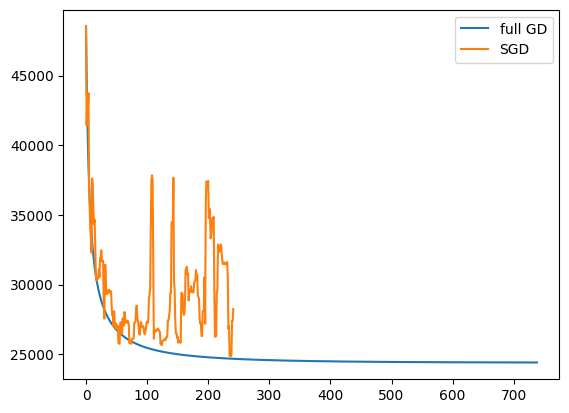

In [7]:
plt.plot(logreg_loss_histories[0], label="full GD")
plt.plot(logreg_loss_histories[1], label="SGD")
plt.legend()
plt.show();

Объявим функции для отображения roc и pr кривых:

In [8]:
def plot_roc_curve(model, X, y):
    probs = model.predict_proba(X)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(y, probs)

    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_pr_curve(model, X, y):
    probs = model.predict_proba(X)
    yhat = model.predict(X)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs)

    plt.title('PR curve')
    plt.plot(lr_recall, lr_precision, 'b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

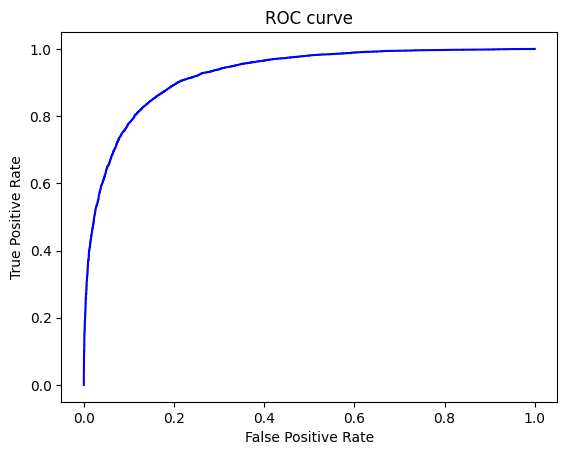

In [9]:
plot_roc_curve(logreg_models[0], X_test, y_test)

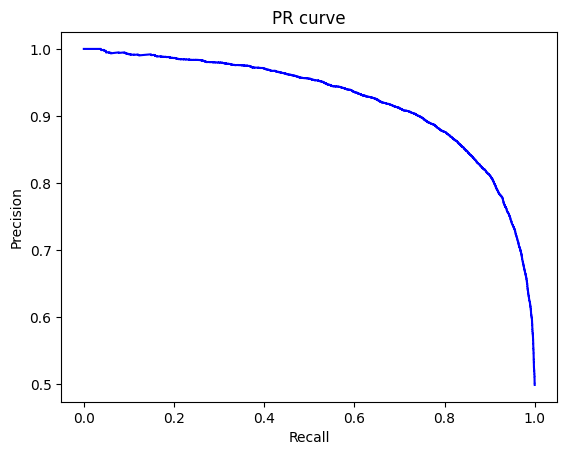

In [10]:
plot_pr_curve(logreg_models[0], X_test, y_test)

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [11]:
from numpy.random import default_rng
PATH_TO_DATASET = "insurance_cases.csv"
# Возьмем подвыборку, чтобы не обучалось слишком долго.
DATA_SIZE = 5_000
TEST_SIZE = 0.2

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

rng = default_rng()
indices = rng.choice(data.shape[0], size=DATA_SIZE, replace=False)

data = data.iloc[indices]
target = target[indices]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 57), (1000, 57), (4000,), (1000,))

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [13]:
cat_columns = list(filter(lambda x: x[-3:] == "cat", X_train.columns))
num_columns = list(set(X_train.columns) - set(cat_columns))

X_train_cat = X_train[cat_columns]
X_train_num = X_train[num_columns]

X_test_cat = X_test[cat_columns]
X_test_num = X_test[num_columns]

In [14]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train_cat).toarray())
X_test_cat = pd.DataFrame(ohe.transform(X_test_cat).toarray())

In [15]:
X_train = pd.concat([X_train_num.reset_index(), X_train_cat.reset_index()], axis=1).to_numpy()
X_test = pd.concat([X_test_num.reset_index(), X_test_cat.reset_index()], axis=1).to_numpy()

In [16]:
X_train.shape, X_test.shape

((4000, 227), (1000, 227))

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [17]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

In [18]:
models_params = [
    {
        "name": "log_reg",
        "model": LogisticRegression(max_iter=1_000)
    },
    {
        "name": "svm",
        "model": SVC(probability=True)
    },
    {
        "name": "knn",
        "model": KNeighborsClassifier()
    },
]

for model_param in models_params:
    model = model_param["model"]
    model_name = model_param["name"]
    start_time = time.time()
    model.fit(X_train, y_train)
    fitting_time = round(time.time() - start_time, 2)

    test_pred = model.predict_proba(X_test)[:,1]
    roc_auc = round(roc_auc_score(y_test, test_pred), 3)
    print(f"Model: {model_name}")
    print(f"Fitting time: {fitting_time} seconds")
    print(f"Roc-auc score: {roc_auc}")
    print("-"*30)

Model: log_reg
Fitting time: 2.23 seconds
Roc-auc score: 0.643
------------------------------
Model: svm
Fitting time: 1.44 seconds
Roc-auc score: 0.549
------------------------------
Model: knn
Fitting time: 0.01 seconds
Roc-auc score: 0.493
------------------------------


Теперь используем GridSearch, чтобы подобрать гиперпараметры.

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
%%time


parameters = {'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']}

lr = LogisticRegression(max_iter=1_000)
clf = GridSearchCV(lr, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train, y_train)
lr_best = clf.best_estimator_
test_pred = lr_best.predict_proba(X_test)[:,1]
print("\n")
roc_auc_score(y_test, test_pred)



CPU times: user 31.6 s, sys: 13.4 s, total: 45 s
Wall time: 29.4 s


0.6322941646682653

In [ ]:
%%time

parameters = {'C': [0.1, 10], 'kernel': ['linear', 'rbf']}

svc = SVC(probability=True)
clf = GridSearchCV(svc, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train, y_train)
svc_best = clf.best_estimator_
test_pred = svc_best.predict_proba(X_test)[:,1]
print("\n")
roc_auc_score(y_test, test_pred)

In [ ]:
%%time

parameters = {'n_neighbors': [5, 10], 'class_weight': [None, 'balanced']}

knc = KNeighborsClassifier()
clf = GridSearchCV(knc, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train, y_train)
knc_best = clf.best_estimator_
test_pred = knc_best.predict_proba(X_test)[:,1]
print("\n")
roc_auc_score(y_test, test_pred)

### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
%%time
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(LogisticRegression(max_iter=400))
selector.fit(X_train_scaled, y_train)
importances_sort = np.argsort(selector.estimator_.coef_)

CPU times: user 77 ms, sys: 26.4 ms, total: 103 ms
Wall time: 169 ms


In [53]:
X_train_subset = X_train_scaled[:, importances_sort[0][-150:]]
X_test_subset = X_test_scaled[:, importances_sort[0][-150:]]
X_train_subset.shape

(4000, 150)

In [56]:
lr = LogisticRegression(max_iter=400)
lr.fit(X_train_subset, y_train)

test_pred = lr.predict_proba(X_test_subset)[:,1]
print("\n")
roc_auc_score(y_test, test_pred)

0.6318373872330707

### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [57]:
selector_200 = SelectFromModel(LogisticRegression(max_iter=400))
selector_200.fit(X_train_scaled, y_train)
importances_sort = np.argsort(selector_200.estimator_.coef_)

X_train_subset = X_train_scaled[:, importances_sort[0][-200:]]
X_test_subset = X_test_scaled[:, importances_sort[0][-200:]]

selector_150 = SelectFromModel(LogisticRegression(max_iter=400))
selector_150.fit(X_train_subset, y_train)
importances_sort = np.argsort(selector_150.estimator_.coef_)

X_train_subset = X_train_subset[:, importances_sort[0][-150:]]
X_test_subset = X_test_subset[:, importances_sort[0][-150:]]

In [58]:
lr = LogisticRegression(max_iter=400)
lr.fit(X_train_subset, y_train)

test_pred = lr.predict_proba(X_test_subset)[:,1]
print("\n")
roc_auc_score(y_test, test_pred)

0.6361387080811541

### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [59]:
log_reg = LogisticRegression()
param_grid = {
    'C': np.arange(0, 1, 0.1)
}
gs = GridSearchCV(log_reg, cv=3, param_grid=param_grid)
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

Число ненулевых весов:

In [63]:
sum(gs.best_estimator_.coef_ != 0)

226

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [ ]:
from sklearn.model_selection import train_test_split

PATH = "/content/NLP_disaster_tweets.csv"
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data.shape

(7613, 5)

### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
pd.DataFrame(data.isna().sum()).T

,id,keyword,location,text,target
0,0,61,2533,0,0


In [ ]:
data = data.fillna("")

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [ ]:
pd.DataFrame(data.apply(lambda x: len(x.unique()))).T

,id,keyword,location,text,target
0,7613,222,3342,7503,2


`- Столбец id можно превратить в столбец индексов.`<br>
`- Кажется, что есть одинаковые посты (возможно, есть наличие дубликатов)`

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

`В принципе классы сбалансированы, хотя первого класса все равно меньше чем второго. Это важно учитывать, так как при дисбалансе нельзя использовать такую метрику как accuracy. Также наша модель может плохо предсказывать тот класс, которого меньше, так как видит мало данных.`

<Axes: xlabel='target', ylabel='count'>

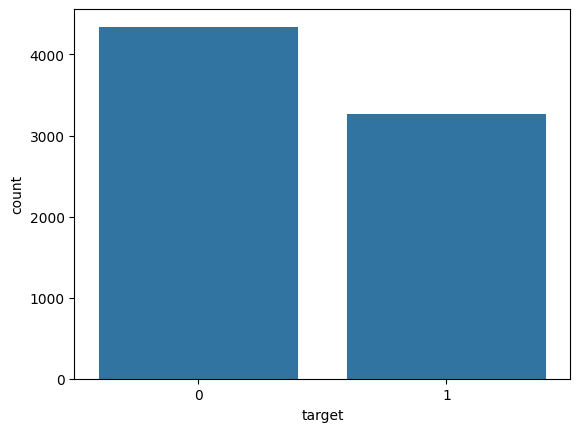

In [ ]:
sns.countplot(data, x="target")

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [ ]:
data = data.set_index('id')

In [ ]:
data.sample(5, random_state=42)

,keyword,location,text,target
id,,,,
3796,destruction,,So you have a new weapon that can cause un-ima...,1
3185,deluge,,The f$&amp;@ing things I do for #GISHWHES Just...,0
7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
191,aftershock,,Aftershock back to school kick off was great. ...,0
9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
data = pd.concat([data.apply(lambda x: x[0] + " " + x[1] + " " + x[2], axis=1), data.target], axis=1)

<ipython-input-14-a67898d925f4>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = pd.concat([data.apply(lambda x: x[0] + " " + x[1] + " " + x[2], axis=1), data.target], axis=1)


In [ ]:
data = data.reset_index(drop=True)

- Наконец, поделите данные на тренировочную и тестовую выборки.

In [ ]:
X = data.drop(columns='target')
y = data['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X_train_vectorized = cnt_vec.fit_transform(X_train.iloc[:, 0].tolist()).toarray()
X_test_vectorized = cnt_vec.transform(X_test.iloc[:, 0].tolist()).toarray()
X_train_vectorized.shape, X_test_vectorized.shape

((5709, 19370), (1904, 19370))

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
%%time

log_reg = LogisticRegression()
log_reg.fit(X_train_vectorized, y_train)
test_pred = log_reg.predict(X_test_vectorized)

f1_score(y_test, test_pred)

CPU times: user 16.8 s, sys: 3.66 s, total: 20.4 s
Wall time: 22.2 s


0.7546444586803331

- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [ ]:
%%time

svc = SVC()
svc.fit(X_train_vectorized, y_train)
test_pred = svc.predict(X_test_vectorized)

f1_score(y_test, test_pred)

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

`В качестве гиперпараметра использовася max_features, который напрямую влияет на количество признаков.`

In [ ]:
cnt_vec = CountVectorizer(max_features=int(X_train.shape[0] / 4))

X_train_vectorized = cnt_vec.fit_transform(X_train.iloc[:, 0].tolist()).toarray()
X_test_vectorized = cnt_vec.transform(X_test.iloc[:, 0].tolist()).toarray()

log_reg = LogisticRegression()
log_reg.fit(X_train_vectorized, y_train)
test_pred = log_reg.predict(X_test_vectorized)

f1_score(y_test, test_pred)

0.7446270543615676

In [ ]:
svc = SVC()
svc.fit(X_train_vectorized, y_train)
test_pred = svc.predict(X_test_vectorized)

f1_score(y_test, test_pred)

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
parameters = {'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']}

lr = LogisticRegression(max_iter=400)
clf = GridSearchCV(lr, parameters, cv=3, scoring='f1')
clf.fit(X_train_vectorized, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=400),
             param_grid={'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']},
             scoring='f1')

In [ ]:
lr_best = clf.best_estimator_
test_pred = lr_best.predict(X_test_vectorized)
f1_score(y_test, test_pred)

0.7450738916256158

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Ваши выводы здесь.

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

## Чей кот?

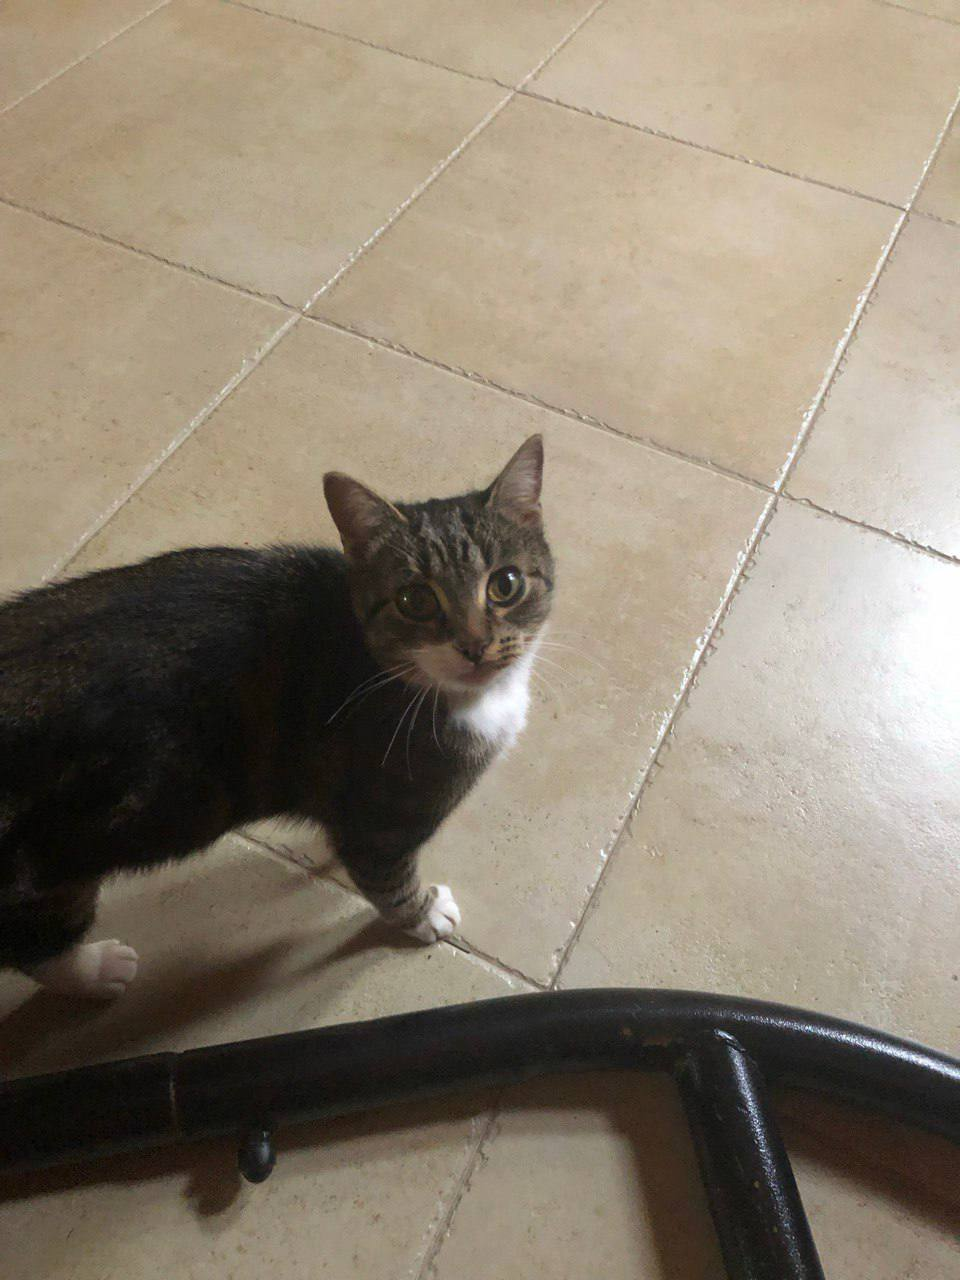